## Implications of Race on California Covid-19 Cases

David Mao

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
import geopandas as gpd
import collections

from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
data = pd.read_csv("COVID-19_Case_Surveillance_Public_Use_Data_with_Geography.csv")
data.head()

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
0,2020-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,Missing,NaN
1,2020-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Missing,Missing,Probable Case,Missing,Missing,Missing,Missing,NaN
2,2020-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,Missing,NaN
3,2020-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,Missing,NaN
4,2020-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,Missing,NaN


#### Data Preprocessing

We have a massive amount of NaN values, along with many other entries deemed "Missing" or "Unknown".

In [3]:
data.isnull().sum()

case_month                                0
res_state                               679
state_fips_code                         679
res_county                          1788654
county_fips_code                    1788654
age_group                            266550
sex                                  705216
race                                4163723
ethnicity                           4995992
case_positive_specimen_interval    17752713
case_onset_interval                13061596
process                                   0
exposure_yn                               0
current_status                            0
symptom_status                            0
hosp_yn                                   0
icu_yn                                    0
death_yn                            1135531
underlying_conditions_yn           22839680
dtype: int64

CDC's own website notes that there are 32 million total cases in the United States, but this dataset only contains 24 million.

In [4]:
len(data)

24441351

The problem does not seem to affect California data as much.

In [5]:
data = data[data["res_state"] == "CA"]
data['case_month'] = pd.to_datetime(data['case_month'], format="%Y-%m")
len(data)

3619884

In [6]:
data.isnull().sum()

case_month                               0
res_state                                0
state_fips_code                          0
res_county                           74589
county_fips_code                     74589
age_group                             8161
sex                                  15140
race                               1181075
ethnicity                          1278267
case_positive_specimen_interval    3619628
case_onset_interval                2279380
process                                  0
exposure_yn                              0
current_status                           0
symptom_status                           0
hosp_yn                                  0
icu_yn                                   0
death_yn                             20175
underlying_conditions_yn           3600763
dtype: int64

In [7]:
cac_map = gpd.read_file('data')
cac_map = cac_map[cac_map['ISLAND'] == 'N']
cac_map.head()

,NAME_PCASE,NAME_UCASE,FMNAME_PC,FMNAME_UC,ABBREV,NUM,ABCODE,FIPS,ANSI,ISLAND,Shape_Leng,Shape_Area,geometry
0,Del Norte,DEL NORTE,Del Norte County,DEL NORTE COUNTY,DEL,8,c008,015,015,N,306175.156646,2.625847e+09,"POLYGON ((-346163.188 440231.625, -346195.812 ..."
1,Siskiyou,SISKIYOU,Siskiyou County,SISKIYOU COUNTY,SIS,47,c047,093,093,N,672205.907573,1.643940e+10,"POLYGON ((-291951.500 447930.719, -290572.656 ..."
5,Modoc,MODOC,Modoc County,MODOC COUNTY,MOD,25,c025,049,049,N,423574.415010,1.088488e+10,"POLYGON ((-120188.047 443056.938, -118144.953 ..."
9,Humboldt,HUMBOLDT,Humboldt County,HUMBOLDT COUNTY,HUM,12,c012,023,023,N,614580.877022,9.281900e+09,"POLYGON ((-339896.812 390343.812, -338720.375 ..."
10,Trinity,TRINITY,Trinity County,TRINITY COUNTY,TRI,53,c053,105,105,N,611269.176825,8.307254e+09,"POLYGON ((-208130.578 370133.250, -208098.922 ..."


Here, we grab general California population and race data.

In [8]:
data_ca_race = pd.read_csv("cc-est2019-alldata-06.csv")
data_ca_race = data_ca_race[data_ca_race["YEAR"] == 12]
data_ca_race = data_ca_race[data_ca_race["AGEGRP"] == 0]

data_ca_race = data_ca_race.groupby("CTYNAME").sum()[["TOT_POP", 
                                                      "AA_MALE", 
                                                      "AA_FEMALE", 
                                                      "WA_MALE", 
                                                      "WA_FEMALE", 
                                                      "BA_MALE", 
                                                      "BA_FEMALE", 
                                                      "NA_MALE", 
                                                      "NA_FEMALE",
                                                      "IAC_MALE", 
                                                      "IAC_FEMALE",]].reset_index()

data_ca_race['CTY'] = data_ca_race["CTYNAME"].str.replace(' County','',regex=True)
data_ca_race['CTY'] = data_ca_race['CTY'].str.upper()


#### Covid-19 in California

We will first observe Covid-19 trends in California.

Text(0.5, 1.0, 'New California Cases Over Time')

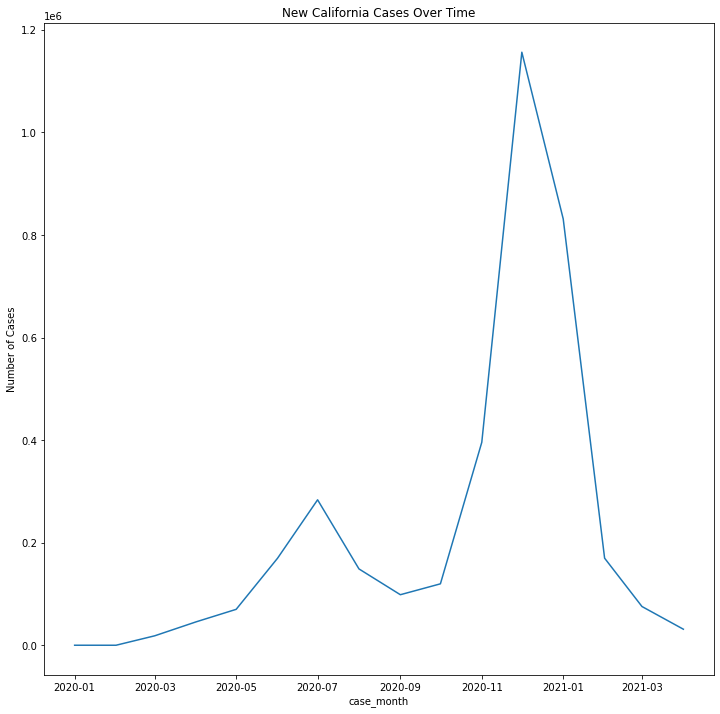

In [9]:
df_time = data.groupby("case_month").count()[['current_status']].reset_index()

fig, ax = plt.subplots(figsize = (12, 12))
sns.lineplot('case_month', 'current_status', data=df_time, ax=ax)
ax.set_ylabel('Month')
ax.set_ylabel('Number of Cases')
ax.set_title('New California Cases Over Time')

#fig.savefig('Figure1.jpg')

In [10]:
df_case_count = data.groupby("res_county")[["current_status"]].count().reset_index()
df_case_count = pd.merge(df_case_count, data_ca_race[['CTY', 'TOT_POP']], left_on='res_county', right_on='CTY', how='right')
df_case_count['current_status'] = df_case_count['current_status'].fillna(0)
df_case_count['pop_perc'] = df_case_count['current_status'] / df_case_count['TOT_POP']

cac_map_overall_case = pd.merge(cac_map, 
                                df_case_count[['CTY', 'current_status', 'pop_perc']], 
                                left_on='NAME_UCASE', 
                                right_on='CTY')

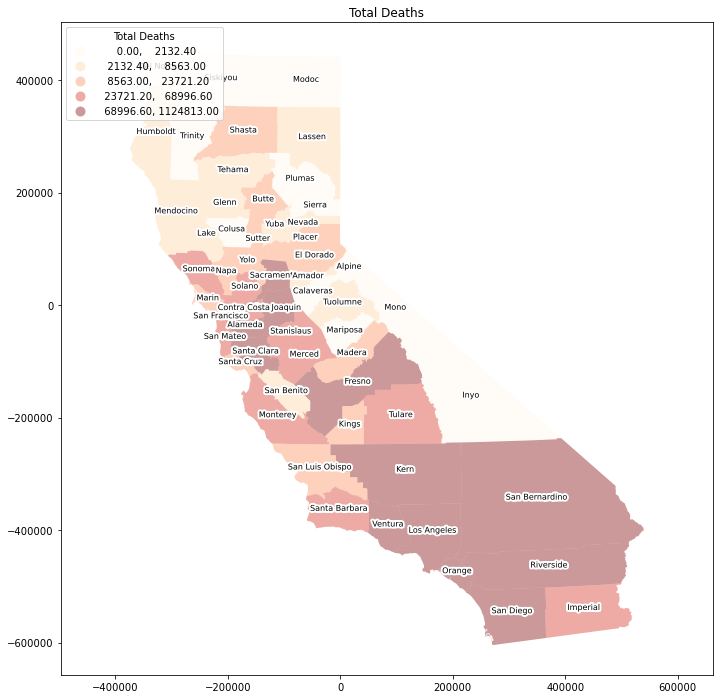

In [11]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.set(title='Total Deaths')
ax.set_box_aspect(1)
cac_map_overall_case.plot(ax=ax, 
                          alpha=0.4, 
                          column='current_status', 
                          legend=True, 
                          legend_kwds={'loc': 'upper left', 'title': 'Total Deaths'},
                          cmap='OrRd', 
                          scheme='quantiles')

cac_map_overall_case.apply(lambda x: ax.annotate(s = x['NAME_PCASE'], 
                                    xy = x.geometry.centroid.coords[0], 
                                    ha = 'center', 
                                    color = 'black', 
                                    fontsize = 8,
                                    path_effects = [pe.withStroke(linewidth = 4, foreground = "white")]), axis = 1);

#fig.savefig('Figure2.jpg')

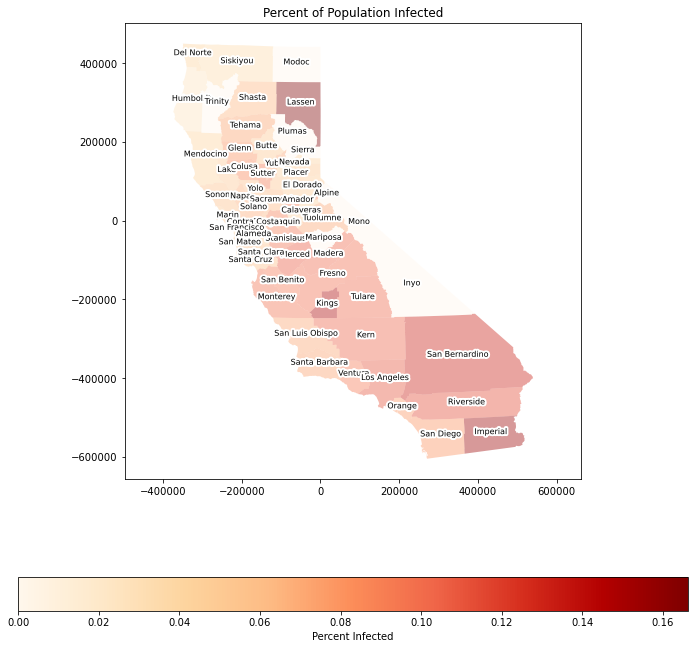

In [12]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.set(title='Percent of Population Infected')
ax.set_box_aspect(1)
cac_map_overall_case.plot(ax=ax, 
                          alpha=0.4, 
                          column='pop_perc', 
                          legend=True, 
                          legend_kwds={'label': "Percent Infected",
                                       'orientation': "horizontal"},
                          cmap='OrRd')

cac_map_overall_case.apply(lambda x: ax.annotate(s = x['NAME_PCASE'], 
                                    xy = x.geometry.centroid.coords[0], 
                                    ha = 'center', 
                                    color = 'black', 
                                    fontsize = 8,
                                    path_effects = [pe.withStroke(linewidth = 4, foreground = "white")]), axis = 1);

#fig.savefig('Figure3.jpg')

In [13]:
data_ca_race['TOT_RACE_MAIN'] = data_ca_race.iloc[:, 2:8].sum(axis=1)

data_ca_race['AA_PERC'] = data_ca_race.iloc[:, 2:4].sum(axis=1) / data_ca_race['TOT_RACE_MAIN']
data_ca_race['WA_PERC'] = data_ca_race.iloc[:, 4:6].sum(axis=1) / data_ca_race['TOT_RACE_MAIN']
data_ca_race['BA_PERC'] = data_ca_race.iloc[:, 6:8].sum(axis=1) / data_ca_race['TOT_RACE_MAIN']
data_ca_race['NH_PERC'] = data_ca_race.iloc[:, 8:10].sum(axis=1) / data_ca_race['TOT_POP']
data_ca_race['IAC_PERC'] = data_ca_race.iloc[:, 10:12].sum(axis=1) / data_ca_race['TOT_POP']

data_ca_race.head()

,CTYNAME,TOT_POP,AA_MALE,AA_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,NA_MALE,NA_FEMALE,IAC_MALE,IAC_FEMALE,CTY,TOT_RACE_MAIN,AA_PERC,WA_PERC,BA_PERC,NH_PERC,IAC_PERC
0,Alameda County,1671329,259991,280400,414416,409177,88167,96201,7534,8227,18534,19263,ALAMEDA,1548352,0.349010,0.531916,0.119074,0.009430,0.022615
1,Alpine County,1129,11,7,424,343,0,4,0,0,154,156,ALPINE,789,0.022814,0.972117,0.005070,0.000000,0.274579
2,Amador County,39752,318,347,19053,16583,955,111,61,55,917,727,AMADOR,37367,0.017796,0.953676,0.028528,0.002918,0.041356
3,Butte County,219186,5461,5523,92754,94988,2316,1842,316,312,4806,5119,BUTTE,202884,0.054139,0.925366,0.020494,0.002865,0.045281
4,Calaveras County,45905,390,469,20794,20958,303,195,58,64,881,977,CALAVERAS,43109,0.019926,0.968522,0.011552,0.002658,0.040475


In [14]:
cac_map_pop = pd.merge(cac_map, 
                       data_ca_race.iloc[:,np.r_[1,12:19]], 
                       left_on='NAME_UCASE', 
                       right_on='CTY')
cac_map_pop.head()

,NAME_PCASE,NAME_UCASE,FMNAME_PC,FMNAME_UC,ABBREV,NUM,ABCODE,FIPS,ANSI,ISLAND,...,Shape_Area,geometry,TOT_POP,CTY,TOT_RACE_MAIN,AA_PERC,WA_PERC,BA_PERC,NH_PERC,IAC_PERC
0,Del Norte,DEL NORTE,Del Norte County,DEL NORTE COUNTY,DEL,8,c008,015,015,N,...,2.625847e+09,"POLYGON ((-346163.188 440231.625, -346195.812 ...",27812,DEL NORTE,23561,0.036543,0.921862,0.041594,0.001942,0.129009
1,Siskiyou,SISKIYOU,Siskiyou County,SISKIYOU COUNTY,SIS,47,c047,093,093,N,...,1.643940e+10,"POLYGON ((-291951.500 447930.719, -290572.656 ...",43539,SISKIYOU,38739,0.017889,0.964919,0.017192,0.003560,0.085762
2,Modoc,MODOC,Modoc County,MODOC COUNTY,MOD,25,c025,049,049,N,...,1.088488e+10,"POLYGON ((-120188.047 443056.938, -118144.953 ...",8841,MODOC,8032,0.013322,0.970867,0.015812,0.003620,0.069449
3,Humboldt,HUMBOLDT,Humboldt County,HUMBOLDT COUNTY,HUM,12,c012,023,023,N,...,9.281900e+09,"POLYGON ((-339896.812 390343.812, -338720.375 ...",135558,HUMBOLDT,118778,0.033087,0.949923,0.016990,0.003312,0.093584
4,Trinity,TRINITY,Trinity County,TRINITY COUNTY,TRI,53,c053,105,105,N,...,8.307254e+09,"POLYGON ((-208130.578 370133.250, -208098.922 ...",12285,TRINITY,10964,0.016782,0.974735,0.008482,0.002361,0.086040


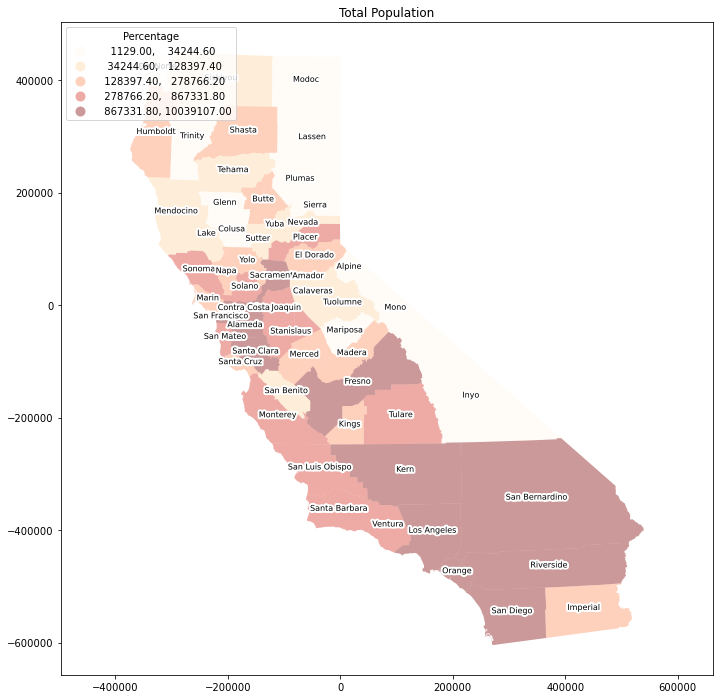

In [15]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.set(title='Total Population')
ax.set_box_aspect(1)
cac_map_pop.plot(ax=ax, 
                 alpha=0.4, 
                 column='TOT_POP', 
                 legend=True, 
                 legend_kwds={'loc': 'upper left', 'title': 'Percentage'},
                 cmap='OrRd', 
                 scheme='quantiles')

cac_map_pop.apply(lambda x: ax.annotate(s = x['NAME_PCASE'], 
                                    xy = x.geometry.centroid.coords[0], 
                                    ha = 'center', 
                                    color = 'black', 
                                    fontsize = 8,
                                    path_effects = [pe.withStroke(linewidth = 4, foreground = "white")]), axis = 1);

#fig.savefig('Figure4.jpg')

### CA Race Statistics

In [16]:
asian_perc = data_ca_race.iloc[:, 2:4].sum().sum() / data_ca_race['TOT_RACE_MAIN'].sum()
white_perc = data_ca_race.iloc[:, 4:6].sum().sum() / data_ca_race['TOT_RACE_MAIN'].sum()
black_perc = data_ca_race.iloc[:, 6:8].sum().sum() / data_ca_race['TOT_RACE_MAIN'].sum()
pi_perc = data_ca_race.iloc[:, 8:10].sum().sum() / data_ca_race['TOT_RACE_MAIN'].sum()
native_perc = data_ca_race.iloc[:, 10:12].sum().sum() / data_ca_race['TOT_RACE_MAIN'].sum()

(-1.1009434119602581,
 1.119811651165422,
 -1.1032389246877683,
 1.1195229045384376)

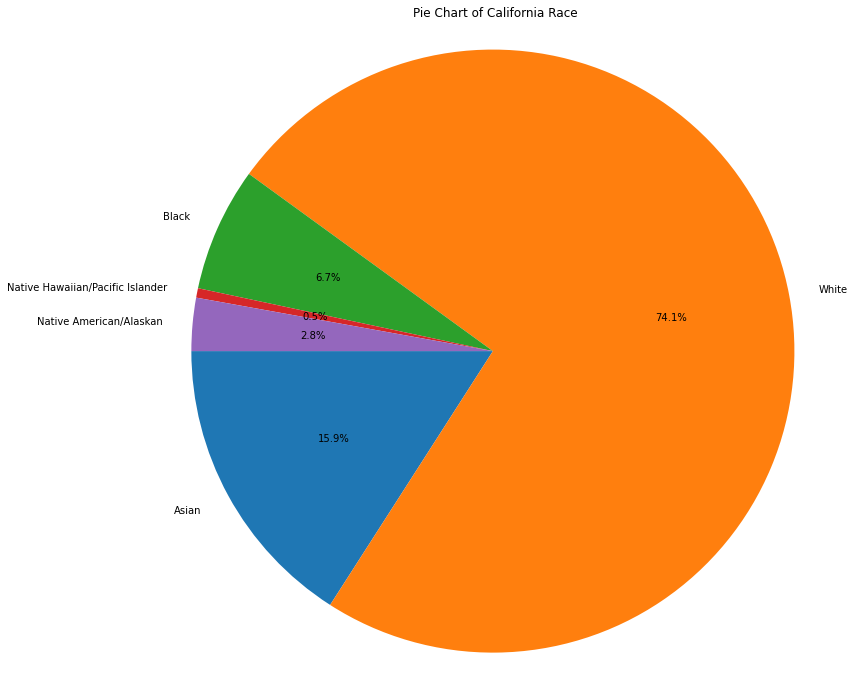

In [17]:
labels = 'Asian', 'White', 'Black', 'Native Hawaiian/Pacific Islander', 'Native American/Alaskan'
sizes = 360*asian_perc, 360*white_perc, 360*black_perc, 350*pi_perc, 360*native_perc

fig, ax = plt.subplots(figsize = (12, 12))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=180)
ax.set_title('Pie Chart of California Race')
ax.axis('equal')

#fig.savefig('Figure5.jpg')

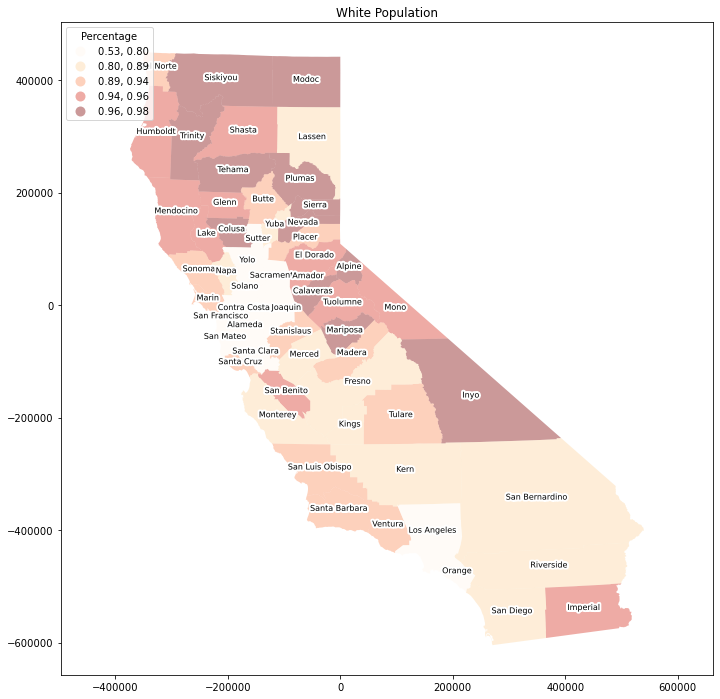

In [18]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.set(title='White Population')
ax.set_box_aspect(1)
cac_map_pop.plot(ax=ax, 
                 alpha=0.4, 
                 column='WA_PERC', 
                 legend=True, 
                 legend_kwds={'loc': 'upper left', 'title': 'Percentage'},
                 cmap='OrRd', 
                 scheme='quantiles')

cac_map_pop.apply(lambda x: ax.annotate(s = x['NAME_PCASE'], 
                                    xy = x.geometry.centroid.coords[0], 
                                    ha = 'center', 
                                    color = 'black', 
                                    fontsize = 8,
                                    path_effects = [pe.withStroke(linewidth = 4, foreground = "white")]), axis = 1);

#fig.savefig('Figure6.jpg')

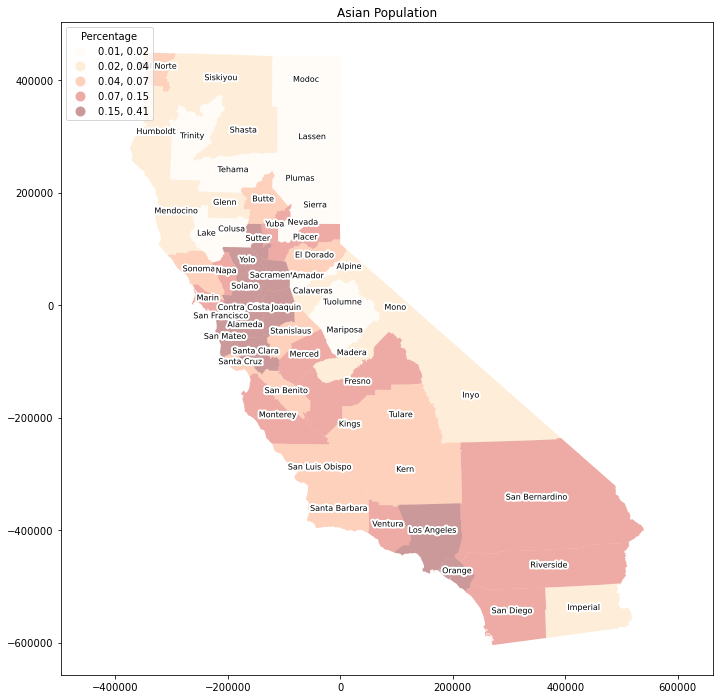

In [19]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.set(title='Asian Population')
ax.set_box_aspect(1)
cac_map_pop.plot(ax=ax, 
                 alpha=0.4, 
                 column='AA_PERC', 
                 legend=True, 
                 legend_kwds={'loc': 'upper left', 'title': 'Percentage'},
                 cmap='OrRd', 
                 scheme='quantiles')

cac_map_pop.apply(lambda x: ax.annotate(s = x['NAME_PCASE'], 
                                    xy = x.geometry.centroid.coords[0], 
                                    ha = 'center', 
                                    color = 'black', 
                                    fontsize = 8,
                                    path_effects = [pe.withStroke(linewidth = 4, foreground = "white")]), axis = 1);

#fig.savefig('Figure7.jpg')

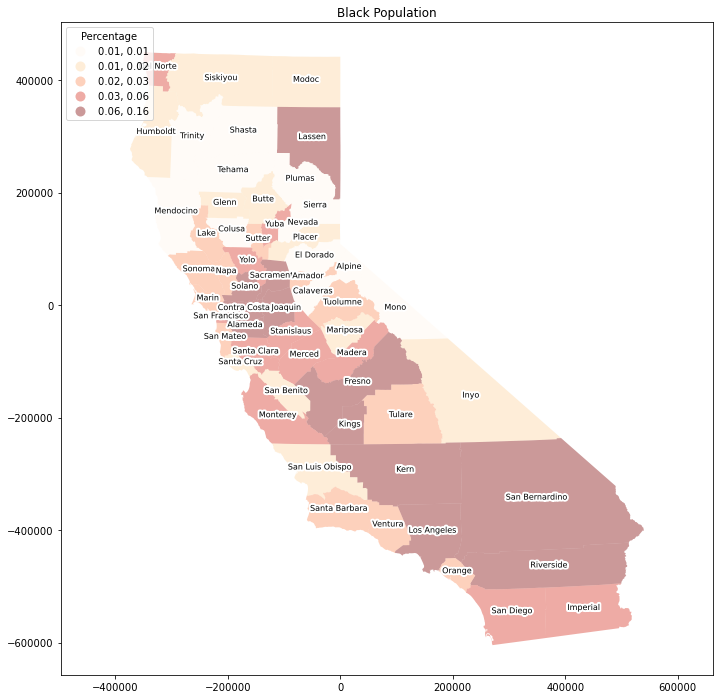

In [20]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.set(title='Black Population')
ax.set_box_aspect(1)
cac_map_pop.plot(ax=ax, 
                 alpha=0.4, 
                 column='BA_PERC', 
                 legend=True, 
                 legend_kwds={'loc': 'upper left', 'title': 'Percentage'},
                 cmap='OrRd', 
                 scheme='quantiles')

cac_map_pop.apply(lambda x: ax.annotate(s = x['NAME_PCASE'], 
                                    xy = x.geometry.centroid.coords[0], 
                                    ha = 'center', 
                                    color = 'black', 
                                    fontsize = 8,
                                    path_effects = [pe.withStroke(linewidth = 4, foreground = "white")]), axis = 1);

#fig.savefig('Figure8.jpg')

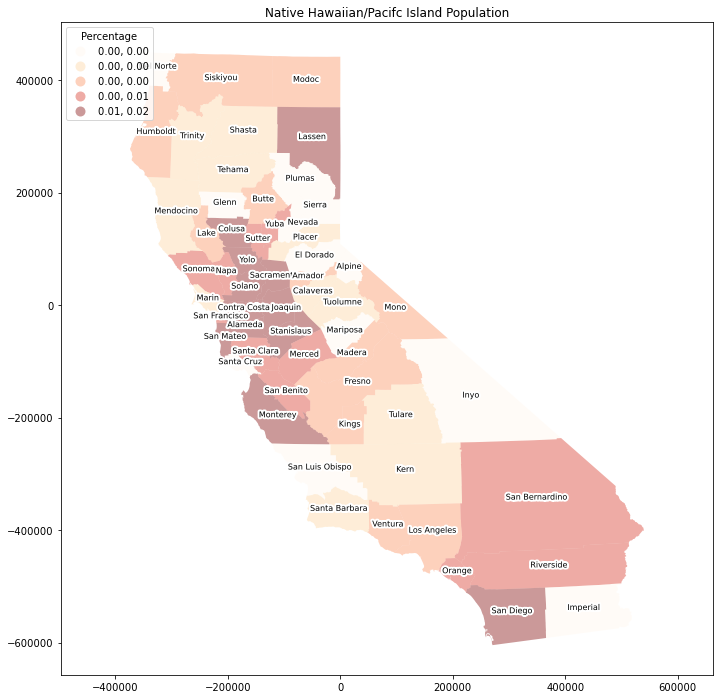

In [21]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.set(title='Native Hawaiian/Pacifc Island Population')
ax.set_box_aspect(1)
cac_map_pop.plot(ax=ax, 
                 alpha=0.4, 
                 column='NH_PERC', 
                 legend=True, 
                 legend_kwds={'loc': 'upper left', 'title': 'Percentage'},
                 cmap='OrRd', 
                 scheme='quantiles')

cac_map_pop.apply(lambda x: ax.annotate(s = x['NAME_PCASE'], 
                                    xy = x.geometry.centroid.coords[0], 
                                    ha = 'center', 
                                    color = 'black', 
                                    fontsize = 8,
                                    path_effects = [pe.withStroke(linewidth = 4, foreground = "white")]), axis = 1);

#fig.savefig('Figure9.jpg')

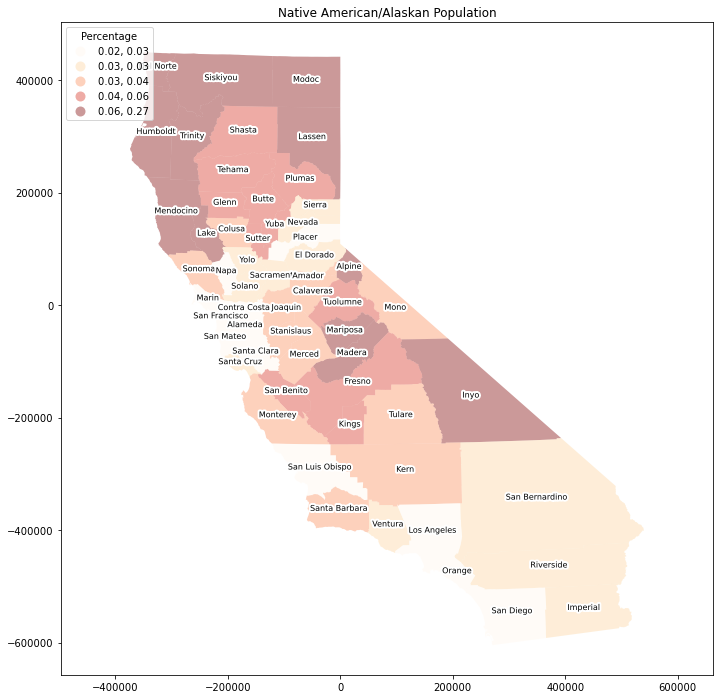

In [22]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.set(title='Native American/Alaskan Population')
ax.set_box_aspect(1)
cac_map_pop.plot(ax=ax, 
                 alpha=0.4,
                 column='IAC_PERC', 
                 legend=True, 
                 legend_kwds={'loc': 'upper left', 'title': 'Percentage'},
                 cmap='OrRd', 
                 scheme='quantiles')

cac_map_pop.apply(lambda x: ax.annotate(s = x['NAME_PCASE'], 
                                    xy = x.geometry.centroid.coords[0], 
                                    ha = 'center', 
                                    color = 'black', 
                                    fontsize = 8,
                                    path_effects = [pe.withStroke(linewidth = 4, foreground = "white")]), axis = 1);

#fig.savefig('Figure10.jpg')

### Preprocessing and Exploring Covid Race Data California

Here, we observe the different race and ethnicities represented in the dataset. Seeing that we have 58% of values in race as unavailable, we need to take a different approach.

In [23]:
data["race"].unique()

array([nan, 'Missing', 'Unknown', 'American Indian/Alaska Native',
       'Asian', 'Black', 'Multiple/Other',
       'Native Hawaiian/Other Pacific Islander', 'White'], dtype=object)

In [24]:
(data['race'].isna().sum() + len(data[(data['race'] == 'Unknown')]) + len(data[(data['race'] == 'Missing')])) / len(data)

0.5877453531660131

Additionally, we have 8% of the records having 'multiple/other' in the race column, which is not specific enough to for us to determine any insightful trends.

In [25]:
len(data[(data['race'] == 'Multiple/Other')]) / len(data)

0.08983658039870891

In [26]:
(len(data[(data['race'] == 'Asian')]) + 
 len(data[(data['race'] == 'Black')]) + 
 len(data[(data['race'] == 'White')]) +
 len(data[(data['race'] == 'Native Hawaiian/Other Pacific Islander')])+
 len(data[(data['race'] == 'American Indian/Alaska Native')])) / len(data)

0.32241806643527804

### Representation of Race in California Covid Cases

We can check the overall Covid-19 representation for each race. We do so by taking the cases labeled by the chosen ethnicity in our data then seeing what percentage each of the three races takes up, then finding the ratio between that and the population percentage that they take up. 

In [27]:
tot_white = len(data[data['race']=='White'])
tot_black = len(data[data['race']=='Black'])
tot_asian = len(data[data['race']=='Asian'])
tot_pi = len(data[data['race']=='Native Hawaiian/Other Pacific Islander'])
tot_native = len(data[data['race']=='American Indian/Alaska Native'])
tot = tot_white + tot_black + tot_asian + tot_pi + tot_native

In [28]:
white_covid_perc = (tot_white / tot) 
white_covid_ratio = white_covid_perc / white_perc
black_covid_perc = (tot_black / tot)
black_covid_ratio = black_covid_perc / black_perc
asian_covid_perc = (tot_asian / tot) 
asian_covid_ratio = asian_covid_perc / asian_perc
pi_covid_perc = (tot_pi / tot) 
pi_covid_ratio = pi_covid_perc / pi_perc
native_covid_perc = (tot_native / tot) 
native_covid_ratio = native_covid_perc / native_perc

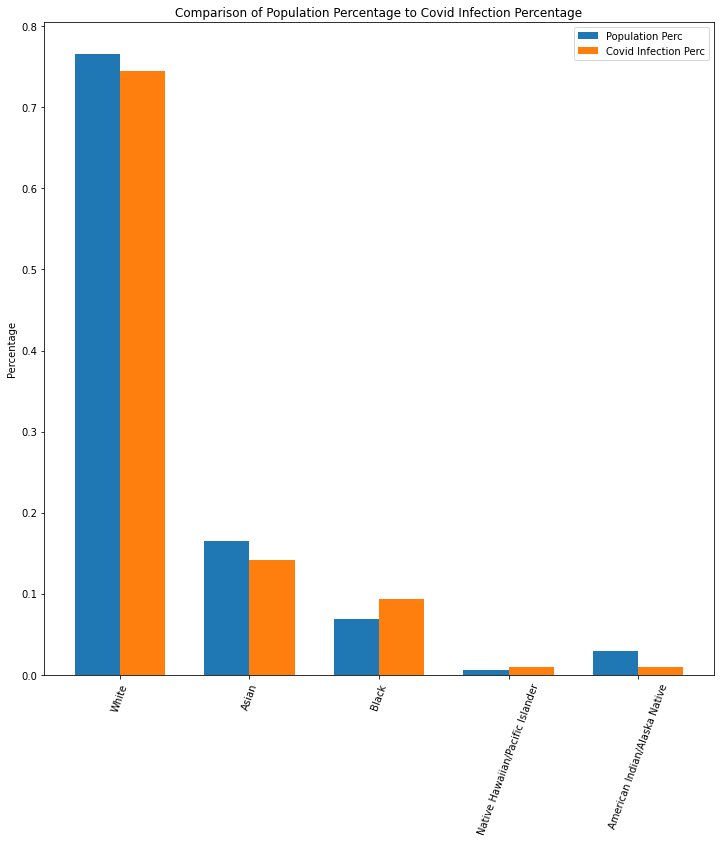

In [29]:
fig, ax = plt.subplots(figsize = (12, 12))
x = np.arange(5)
width = 0.35
pop_perc = [white_perc, asian_perc, black_perc, pi_perc, native_perc]
covid_perc = [white_covid_perc, asian_covid_perc, black_covid_perc, pi_covid_perc, native_covid_perc]
ax.bar(x - width/2, pop_perc, width, label='Population Perc')
ax.bar(x + width/2, covid_perc, width, label='Covid Infection Perc')
ax.set_ylabel('Percentage')
ax.set_title('Comparison of Population Percentage to Covid Infection Percentage')
ax.set_xticks(x)
ax.set_xticklabels(['White','Asian','Black','Native Hawaiian/Pacific Islander', 'American Indian/Alaska Native'])
plt.xticks(rotation=70)
ax.legend()

#fig.savefig('Figure11.jpg')

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'White'),
  Text(1, 0, 'Asian'),
  Text(2, 0, 'Black'),
  Text(3, 0, 'Native Hawaiian/Pacific Islander'),
  Text(4, 0, 'American Indian/Alaska Native')])

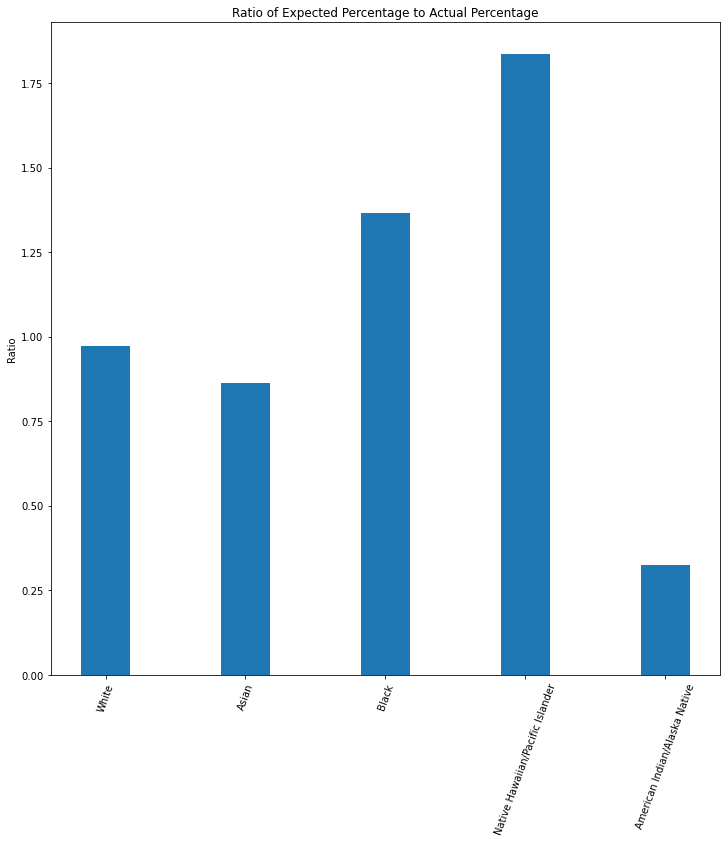

In [30]:
fig, ax = plt.subplots(figsize = (12, 12))
x = np.arange(5)
width = 0.35
covid_ratio = [white_covid_ratio, asian_covid_ratio, black_covid_ratio, pi_covid_ratio, native_covid_ratio]
ax.bar(x, covid_ratio, width)
ax.set_ylabel('Ratio')
ax.set_title('Ratio of Expected Percentage to Actual Percentage')
ax.set_xticks(x)
ax.set_xticklabels(['White','Asian','Black','Native Hawaiian/Pacific Islander', 'American Indian/Alaska Native'])
plt.xticks(rotation=70)

#fig.savefig('Figure12.jpg')

In [31]:
df1 = data[data['race']=='White'].groupby("case_month").count()[['symptom_status']].reset_index()
df2 = data[data['race']=='Asian'].groupby("case_month").count()[['symptom_status']].reset_index()
df3 = data[data['race']=='Black'].groupby("case_month").count()[['symptom_status']].reset_index()
df4 = data[data['race']=='Native Hawaiian/Other Pacific Islander'].groupby("case_month").count()[['symptom_status']].reset_index()
df5 = data[data['race']=='American Indian/Alaska Native'].groupby("case_month").count()[['symptom_status']].reset_index()
df_race_time = df1.merge(df2, left_on='case_month', right_on='case_month',suffixes=('_white', '_asian'))
df_race_time = df_race_time.merge(df3, left_on='case_month', right_on='case_month')
df_race_time.rename(columns={'symptom_status':'symptom_status_black'}, inplace=True)
df_race_time = df_race_time.merge(df4, left_on='case_month', right_on='case_month')
df_race_time.rename(columns={'symptom_status':'symptom_status_pi'}, inplace=True)
df_race_time = df_race_time.merge(df5, left_on='case_month', right_on='case_month')
df_race_time.rename(columns={'symptom_status':'symptom_status_native'}, inplace=True)
df_race_time['tot_cases'] = df_race_time.iloc[:, 1:6].sum(axis=1)
df_race_time['white_perc_cases'] = df_race_time['symptom_status_white'] / df_race_time['tot_cases']
df_race_time['asian_perc_cases'] = df_race_time['symptom_status_asian'] / df_race_time['tot_cases']
df_race_time['black_perc_cases'] = df_race_time['symptom_status_black'] / df_race_time['tot_cases']
df_race_time['pi_perc_cases'] = df_race_time['symptom_status_pi'] / df_race_time['tot_cases']
df_race_time['native_perc_cases'] = df_race_time['symptom_status_native'] / df_race_time['tot_cases']
df_race_time

,case_month,symptom_status_white,symptom_status_asian,symptom_status_black,symptom_status_pi,symptom_status_native,tot_cases,white_perc_cases,asian_perc_cases,black_perc_cases,pi_perc_cases,native_perc_cases
0,2020-05-01,19549,2521,1895,76,66,24107,0.810926,0.104575,0.078608,0.003153,0.002738
1,2020-06-01,43473,3675,3804,196,147,51295,0.847510,0.071644,0.074159,0.003821,0.002866
2,2020-07-01,68437,7590,7880,634,451,84992,0.805217,0.089303,0.092715,0.007460,0.005306
3,2020-08-01,34834,4791,4073,200,163,44061,0.790586,0.108736,0.092440,0.004539,0.003699
4,2020-09-01,23419,2943,2279,88,48,28777,0.813810,0.102269,0.079195,0.003058,0.001668
5,2020-10-01,27886,3521,2855,149,161,34572,0.806607,0.101845,0.082581,0.004310,0.004657
6,2020-11-01,94438,16378,10671,1007,788,123282,0.766032,0.132850,0.086558,0.008168,0.006392
7,2020-12-01,244401,53255,33907,4302,4104,339969,0.718892,0.156647,0.099736,0.012654,0.012072
8,2021-01-01,212379,49521,28967,4067,4684,299618,0.708833,0.165280,0.096680,0.013574,0.015633
9,2021-02-01,47383,10863,6329,510,487,65572,0.722610,0.165665,0.096520,0.007778,0.007427


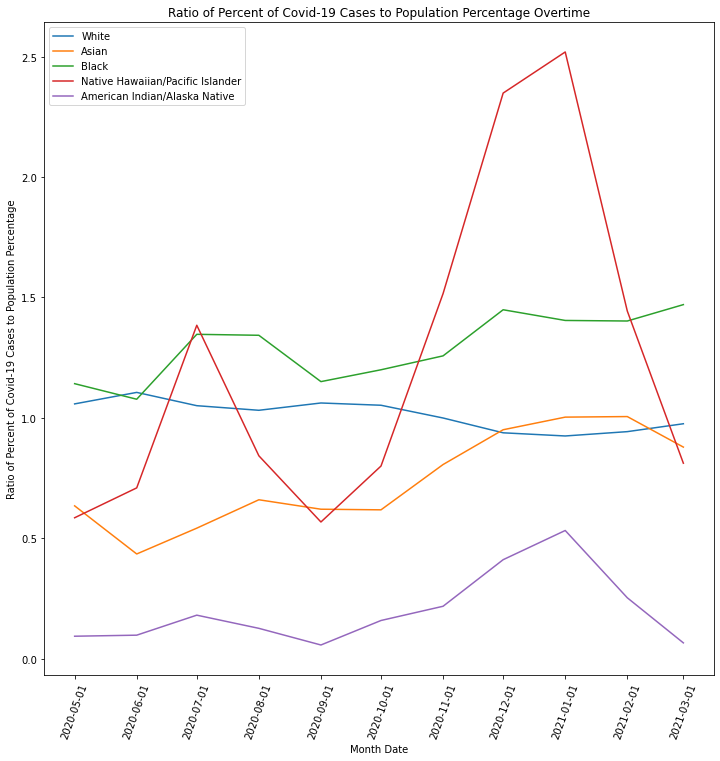

In [32]:
fig, ax = plt.subplots(figsize = (12, 12))
plt.plot(df_race_time['case_month'], df_race_time['white_perc_cases'] / white_perc, label='White')
plt.plot(df_race_time['case_month'], df_race_time['asian_perc_cases'] / asian_perc, label='Asian')
plt.plot(df_race_time['case_month'], df_race_time['black_perc_cases'] / black_perc, label='Black')
plt.plot(df_race_time['case_month'], df_race_time['pi_perc_cases'] / pi_perc, label='Native Hawaiian/Pacific Islander')
plt.plot(df_race_time['case_month'], df_race_time['native_perc_cases'] / native_perc, label='American Indian/Alaska Native')
ax.set_xticks(df_race_time['case_month'])
ax.set_xlabel('Month Date')
ax.set_ylabel('Ratio of Percent of Covid-19 Cases to Population Percentage')
ax.set_title('Ratio of Percent of Covid-19 Cases to Population Percentage Overtime')
plt.xticks(rotation=70)
plt.legend()

#fig.savefig('Figure13.jpg')

In [33]:
df_covid_race_county = data.groupby(['res_county', 'race']).count()['current_status'].reset_index()
df_covid_race_county = df_covid_race_county[(df_covid_race_county['race']=='American Indian/Alaska Native') |
                     (df_covid_race_county['race']=='Asian') |
                     (df_covid_race_county['race']=='Black') |
                     (df_covid_race_county['race']=='Native Hawaiian/Other Pacific Islander') |
                     (df_covid_race_county['race']=='White') ]

df_covid_race_county['count'] = df_covid_race_county.groupby('res_county')['current_status'].transform('sum')
df_covid_race_county['perc'] = df_covid_race_county['current_status'] / df_covid_race_county['count']  
df_covid_race_county.head()

,res_county,race,current_status,count,perc
0,ALAMEDA,American Indian/Alaska Native,51,25457,0.002003
1,ALAMEDA,Asian,8379,25457,0.329143
2,ALAMEDA,Black,5592,25457,0.219665
4,ALAMEDA,Native Hawaiian/Other Pacific Islander,301,25457,0.011824
6,ALAMEDA,White,11134,25457,0.437365


In [34]:
cac_map_race_case = pd.merge(cac_map, 
                           data_ca_race[['CTY', 'AA_PERC', 'WA_PERC', 'BA_PERC', 'NH_PERC', 'IAC_PERC']], 
                           left_on='NAME_UCASE', 
                           right_on='CTY')
cac_map_race_case.head()

,NAME_PCASE,NAME_UCASE,FMNAME_PC,FMNAME_UC,ABBREV,NUM,ABCODE,FIPS,ANSI,ISLAND,Shape_Leng,Shape_Area,geometry,CTY,AA_PERC,WA_PERC,BA_PERC,NH_PERC,IAC_PERC
0,Del Norte,DEL NORTE,Del Norte County,DEL NORTE COUNTY,DEL,8,c008,015,015,N,306175.156646,2.625847e+09,"POLYGON ((-346163.188 440231.625, -346195.812 ...",DEL NORTE,0.036543,0.921862,0.041594,0.001942,0.129009
1,Siskiyou,SISKIYOU,Siskiyou County,SISKIYOU COUNTY,SIS,47,c047,093,093,N,672205.907573,1.643940e+10,"POLYGON ((-291951.500 447930.719, -290572.656 ...",SISKIYOU,0.017889,0.964919,0.017192,0.003560,0.085762
2,Modoc,MODOC,Modoc County,MODOC COUNTY,MOD,25,c025,049,049,N,423574.415010,1.088488e+10,"POLYGON ((-120188.047 443056.938, -118144.953 ...",MODOC,0.013322,0.970867,0.015812,0.003620,0.069449
3,Humboldt,HUMBOLDT,Humboldt County,HUMBOLDT COUNTY,HUM,12,c012,023,023,N,614580.877022,9.281900e+09,"POLYGON ((-339896.812 390343.812, -338720.375 ...",HUMBOLDT,0.033087,0.949923,0.016990,0.003312,0.093584
4,Trinity,TRINITY,Trinity County,TRINITY COUNTY,TRI,53,c053,105,105,N,611269.176825,8.307254e+09,"POLYGON ((-208130.578 370133.250, -208098.922 ...",TRINITY,0.016782,0.974735,0.008482,0.002361,0.086040


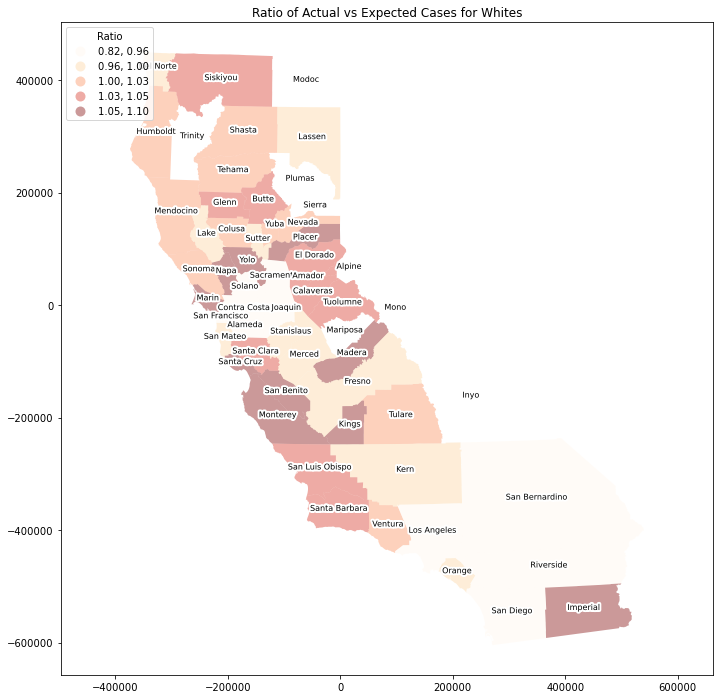

In [35]:
cac_map_race_case_white = pd.merge(cac_map_race_case, 
                                   df_covid_race_county[df_covid_race_county['race']=='White'][['res_county', 'perc']], 
                                   left_on='NAME_UCASE', 
                                   right_on='res_county',
                                   how='left')
cac_map_race_case_white['ratio'] = cac_map_race_case_white['perc'] / cac_map_race_case_white['WA_PERC']

fig, ax = plt.subplots(figsize = (12, 12))
ax.set(title='Ratio of Actual vs Expected Cases for Whites')
ax.set_box_aspect(1)
cac_map_race_case_white.plot(ax=ax, 
                          alpha=0.4, 
                          column='ratio', 
                          legend=True, 
                          legend_kwds={'loc': 'upper left', 'title': 'Ratio'},
                          cmap='OrRd', 
                          scheme='quantiles')

cac_map_race_case_white.apply(lambda x: ax.annotate(s = x['NAME_PCASE'], 
                                    xy = x.geometry.centroid.coords[0], 
                                    ha = 'center', 
                                    color = 'black', 
                                    fontsize = 8,
                                    path_effects = [pe.withStroke(linewidth = 4, foreground = "white")]), axis = 1);

#fig.savefig('Figure14.jpg')

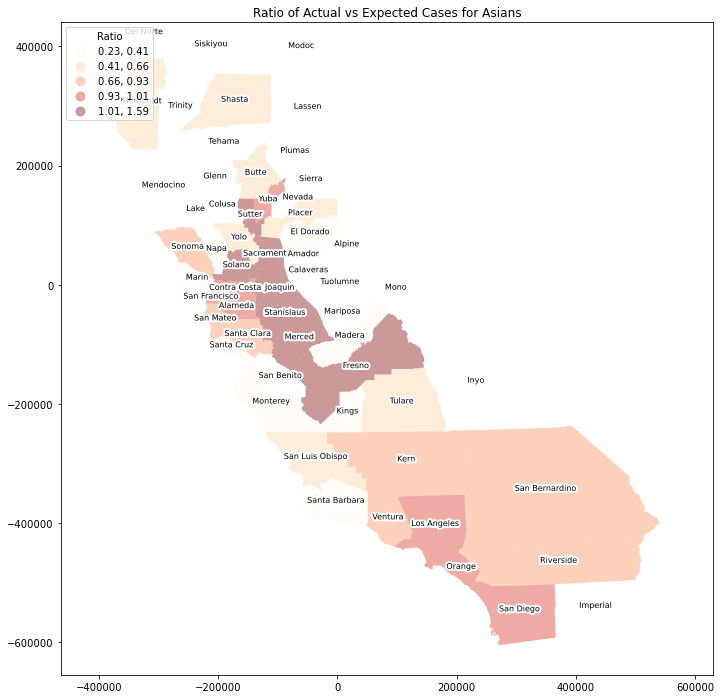

In [36]:
cac_map_race_case_asian = pd.merge(cac_map_race_case, 
                                   df_covid_race_county[df_covid_race_county['race']=='Asian'][['res_county', 'perc']], 
                                   left_on='NAME_UCASE', 
                                   right_on='res_county',
                                   how='left')
cac_map_race_case_asian['ratio'] = cac_map_race_case_asian['perc'] / cac_map_race_case_asian['AA_PERC']

fig, ax = plt.subplots(figsize = (12, 12))
ax.set(title='Ratio of Actual vs Expected Cases for Asians')
ax.set_box_aspect(1)
cac_map_race_case_asian.plot(ax=ax, 
                          alpha=0.4, 
                          column='ratio', 
                          legend=True, 
                          legend_kwds={'loc': 'upper left', 'title': 'Ratio'},
                          cmap='OrRd', 
                          scheme='quantiles')

cac_map_race_case_asian.apply(lambda x: ax.annotate(s = x['NAME_PCASE'], 
                                    xy = x.geometry.centroid.coords[0], 
                                    ha = 'center', 
                                    color = 'black', 
                                    fontsize = 8,
                                    path_effects = [pe.withStroke(linewidth = 4, foreground = "white")]), axis = 1);

#fig.savefig('Figure15.jpg')

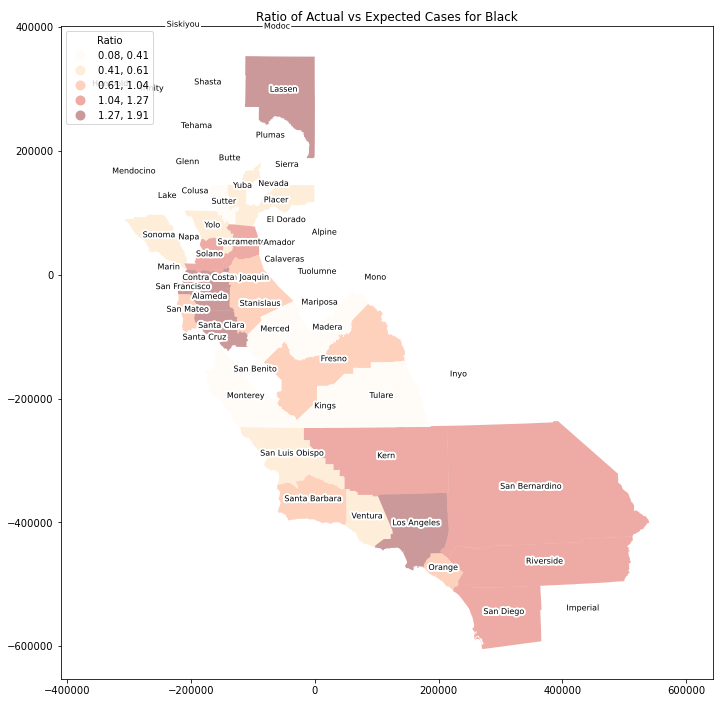

In [37]:
cac_map_race_case_black = pd.merge(cac_map_race_case, 
                                   df_covid_race_county[df_covid_race_county['race']=='Black'][['res_county', 'perc']], 
                                   left_on='NAME_UCASE', 
                                   right_on='res_county',
                                   how='left')
cac_map_race_case_black['ratio'] = cac_map_race_case_black['perc'] / cac_map_race_case_black['BA_PERC']

fig, ax = plt.subplots(figsize = (12, 12))
ax.set(title='Ratio of Actual vs Expected Cases for Black')
ax.set_box_aspect(1)
cac_map_race_case_black.plot(ax=ax, 
                          alpha=0.4, 
                          column='ratio', 
                          legend=True, 
                          legend_kwds={'loc': 'upper left', 'title': 'Ratio'},
                          cmap='OrRd', 
                          scheme='quantiles')

cac_map_race_case_black.apply(lambda x: ax.annotate(s = x['NAME_PCASE'], 
                                    xy = x.geometry.centroid.coords[0], 
                                    ha = 'center', 
                                    color = 'black', 
                                    fontsize = 8,
                                    path_effects = [pe.withStroke(linewidth = 4, foreground = "white")]), axis = 1);

#fig.savefig('Figure16.jpg')

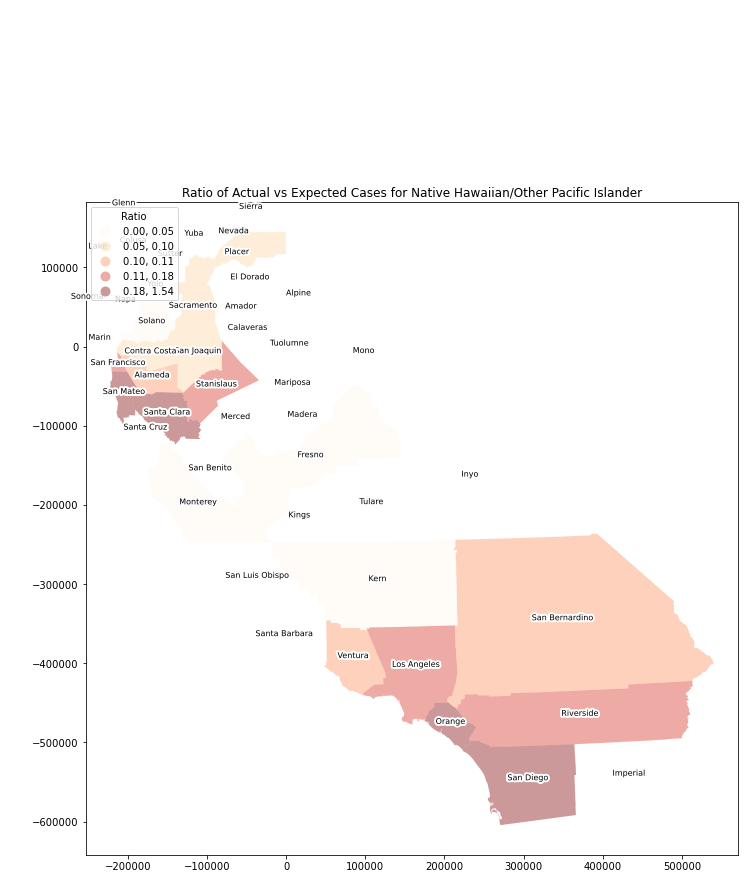

In [38]:
cac_map_race_case_pi = pd.merge(cac_map_race_case, 
                                   df_covid_race_county[df_covid_race_county['race']=='Native Hawaiian/Other Pacific Islander'][['res_county', 'perc']], 
                                   left_on='NAME_UCASE', 
                                   right_on='res_county',
                                   how='left')
cac_map_race_case_pi['ratio'] = cac_map_race_case_pi['perc'] / cac_map_race_case_pi['BA_PERC']

fig, ax = plt.subplots(figsize = (12, 12))
ax.set(title='Ratio of Actual vs Expected Cases for Native Hawaiian/Other Pacific Islander')
ax.set_box_aspect(1)
cac_map_race_case_pi.plot(ax=ax, 
                          alpha=0.4, 
                          column='ratio', 
                          legend=True, 
                          legend_kwds={'loc': 'upper left', 'title': 'Ratio'},
                          cmap='OrRd', 
                          scheme='quantiles')

cac_map_race_case_pi.apply(lambda x: ax.annotate(s = x['NAME_PCASE'], 
                                    xy = x.geometry.centroid.coords[0], 
                                    ha = 'center', 
                                    color = 'black', 
                                    fontsize = 8,
                                    path_effects = [pe.withStroke(linewidth = 4, foreground = "white")]), axis = 1);

#fig.savefig('Figure17.jpg')

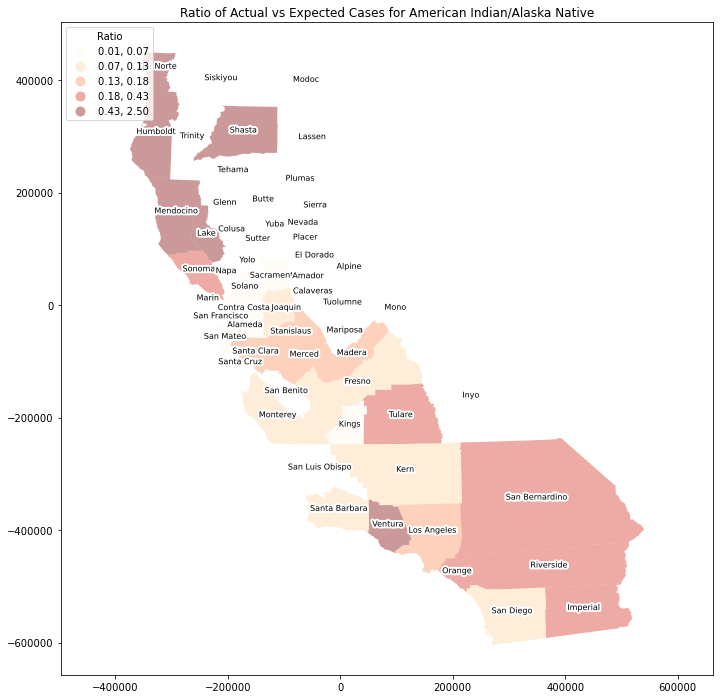

In [39]:
cac_map_race_case_na = pd.merge(cac_map_race_case, 
                                   df_covid_race_county[df_covid_race_county['race']=='American Indian/Alaska Native'][['res_county', 'perc']], 
                                   left_on='NAME_UCASE', 
                                   right_on='res_county',
                                   how='left')
cac_map_race_case_na['ratio'] = cac_map_race_case_na['perc'] / cac_map_race_case_pi['BA_PERC']

fig, ax = plt.subplots(figsize = (12, 12))
ax.set(title='Ratio of Actual vs Expected Cases for American Indian/Alaska Native')
ax.set_box_aspect(1)
cac_map_race_case_na.plot(ax=ax, 
                          alpha=0.4, 
                          column='ratio', 
                          legend=True, 
                          legend_kwds={'loc': 'upper left', 'title': 'Ratio'},
                          cmap='OrRd', 
                          scheme='quantiles')

cac_map_race_case_na.apply(lambda x: ax.annotate(s = x['NAME_PCASE'], 
                                    xy = x.geometry.centroid.coords[0], 
                                    ha = 'center', 
                                    color = 'black', 
                                    fontsize = 8,
                                    path_effects = [pe.withStroke(linewidth = 4, foreground = "white")]), axis = 1);

#fig.savefig('Figure18.jpg')

### California County Poverty Rates

Credit: ppic.org

In [40]:
data_pov = pd.read_csv("poverty.csv")
data_pov['Rate'] = data_pov['Rate'].str.rstrip('%').astype('float') / 100.0
data_pov.head()

,County,Rate,Rate margin of error (% pt)
0,Alameda,0.088,0.6
1,Alpine,0.116,2.2
2,Amador,0.116,2.2
3,Butte,0.177,2.1
4,Calaveras,0.116,2.2


In [41]:
cac_map_poverty = pd.merge(cac_map, 
                           data_pov, 
                           left_on='NAME_PCASE', 
                           right_on='County')

cac_map_poverty.head()

,NAME_PCASE,NAME_UCASE,FMNAME_PC,FMNAME_UC,ABBREV,NUM,ABCODE,FIPS,ANSI,ISLAND,Shape_Leng,Shape_Area,geometry,County,Rate,Rate margin of error (% pt)
0,Del Norte,DEL NORTE,Del Norte County,DEL NORTE COUNTY,DEL,8,c008,015,015,N,306175.156646,2.625847e+09,"POLYGON ((-346163.188 440231.625, -346195.812 ...",Del Norte,0.152,2.6
1,Siskiyou,SISKIYOU,Siskiyou County,SISKIYOU COUNTY,SIS,47,c047,093,093,N,672205.907573,1.643940e+10,"POLYGON ((-291951.500 447930.719, -290572.656 ...",Siskiyou,0.152,2.6
2,Modoc,MODOC,Modoc County,MODOC COUNTY,MOD,25,c025,049,049,N,423574.415010,1.088488e+10,"POLYGON ((-120188.047 443056.938, -118144.953 ...",Modoc,0.152,2.6
3,Humboldt,HUMBOLDT,Humboldt County,HUMBOLDT COUNTY,HUM,12,c012,023,023,N,614580.877022,9.281900e+09,"POLYGON ((-339896.812 390343.812, -338720.375 ...",Humboldt,0.206,3.6
4,Trinity,TRINITY,Trinity County,TRINITY COUNTY,TRI,53,c053,105,105,N,611269.176825,8.307254e+09,"POLYGON ((-208130.578 370133.250, -208098.922 ...",Trinity,0.180,3.5


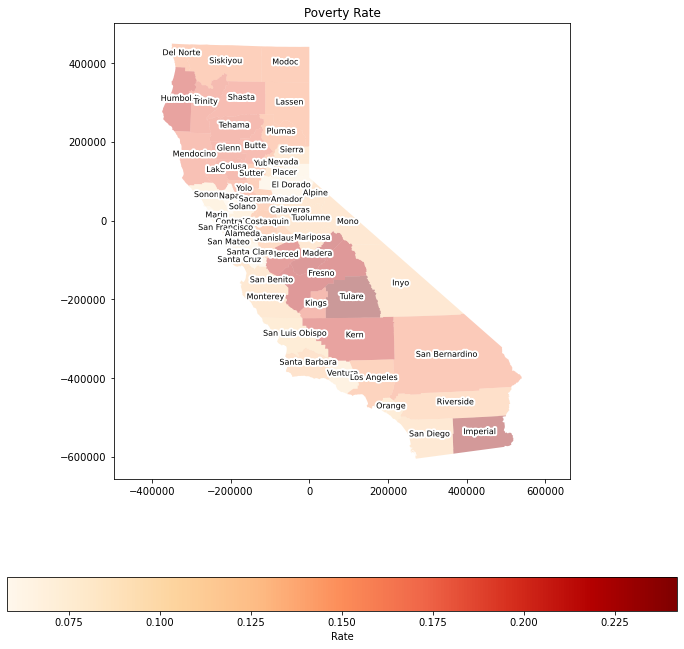

In [42]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.set(title='Poverty Rate')
ax.set_box_aspect(1)
cac_map_poverty.plot(ax=ax, 
                          alpha=0.4, 
                          column='Rate', 
                          legend=True, 
                          legend_kwds={'label': "Rate",
                                       'orientation': "horizontal"},
                          cmap='OrRd')

cac_map_poverty.apply(lambda x: ax.annotate(s = x['NAME_PCASE'], 
                                    xy = x.geometry.centroid.coords[0], 
                                    ha = 'center', 
                                    color = 'black', 
                                    fontsize = 8,
                                    path_effects = [pe.withStroke(linewidth = 4, foreground = "white")]), axis = 1);

#fig.savefig('Figure19.jpg')

In [43]:
cac_tot = pd.merge(cac_map_overall_case[['FMNAME_PC', 'pop_perc']], 
                   cac_map_poverty[['FMNAME_PC', 'Rate']], 
                   left_on='FMNAME_PC', 
                   right_on='FMNAME_PC')

cac_tot.head()

,FMNAME_PC,pop_perc,Rate
0,Del Norte County,0.043291,0.152
1,Siskiyou County,0.034865,0.152
2,Modoc County,0.000000,0.152
3,Humboldt County,0.026203,0.206
4,Trinity County,0.000000,0.180


Text(0.5, 1.0, 'Poverty Rate vs Infected Percentage')

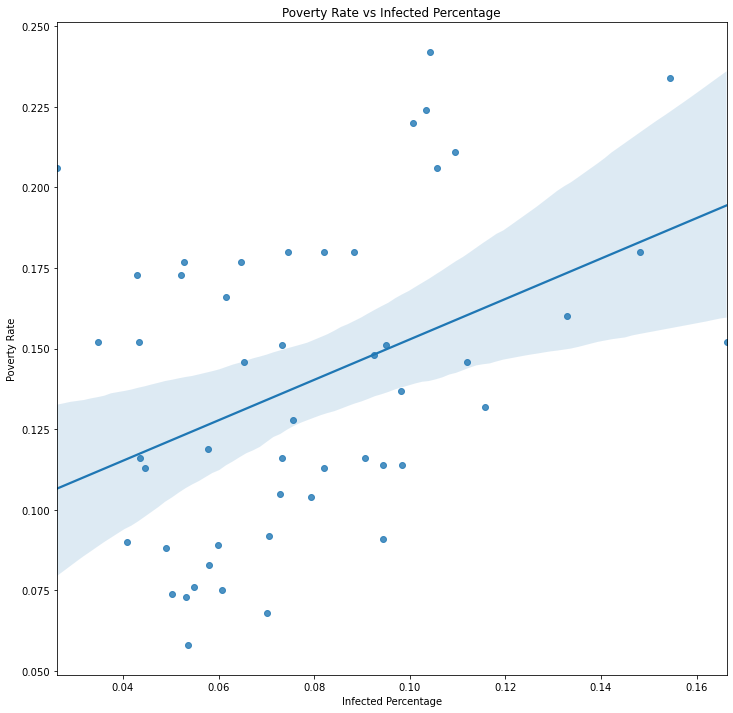

In [44]:
fig, ax = plt.subplots(figsize = (12, 12))
sns.regplot('pop_perc', 'Rate', data=cac_tot[cac_tot['pop_perc']>0], ax=ax)
ax.set_xlabel('Infected Percentage')
ax.set_ylabel('Poverty Rate')
ax.set_title('Poverty Rate vs Infected Percentage')

#fig.savefig('Figure20.jpg')

In [45]:
cac_tot[cac_tot['pop_perc']>0].corr()

,pop_perc,Rate
pop_perc,1.000000,0.408032
Rate,0.408032,1.000000


### Health Insurance

credit: chcf.org

In [46]:
data_health_care = pd.read_csv("Health-Insurance-Coverage.csv")
data_health_care = data_health_care[data_health_care['agecat']==0]
data_health_care = data_health_care[data_health_care['racecat']==0]
data_health_care = data_health_care[data_health_care['sexcat']==0]
data_health_care = data_health_care[data_health_care['iprcat']==0]
data_health_care = data_health_care[['PCTELIG','county_name']]
data_health_care['county_name'] = data_health_care['county_name'].str.replace(' County\s+','',regex=True)
data_health_care['PCTELIG'] = data_health_care['PCTELIG'] / 100 
data_health_care.head()

,PCTELIG,county_name
359,0.050,Alameda
455,0.070,Alpine
551,0.060,Amador
647,0.077,Butte
743,0.074,Calaveras


In [47]:
cac_map_uninsured = pd.merge(cac_map, 
                           data_health_care, 
                           left_on='NAME_PCASE', 
                           right_on='county_name')
cac_map_uninsured.head()

,NAME_PCASE,NAME_UCASE,FMNAME_PC,FMNAME_UC,ABBREV,NUM,ABCODE,FIPS,ANSI,ISLAND,Shape_Leng,Shape_Area,geometry,PCTELIG,county_name
0,Del Norte,DEL NORTE,Del Norte County,DEL NORTE COUNTY,DEL,8,c008,015,015,N,306175.156646,2.625847e+09,"POLYGON ((-346163.188 440231.625, -346195.812 ...",0.073,Del Norte
1,Siskiyou,SISKIYOU,Siskiyou County,SISKIYOU COUNTY,SIS,47,c047,093,093,N,672205.907573,1.643940e+10,"POLYGON ((-291951.500 447930.719, -290572.656 ...",0.084,Siskiyou
2,Modoc,MODOC,Modoc County,MODOC COUNTY,MOD,25,c025,049,049,N,423574.415010,1.088488e+10,"POLYGON ((-120188.047 443056.938, -118144.953 ...",0.094,Modoc
3,Humboldt,HUMBOLDT,Humboldt County,HUMBOLDT COUNTY,HUM,12,c012,023,023,N,614580.877022,9.281900e+09,"POLYGON ((-339896.812 390343.812, -338720.375 ...",0.082,Humboldt
4,Trinity,TRINITY,Trinity County,TRINITY COUNTY,TRI,53,c053,105,105,N,611269.176825,8.307254e+09,"POLYGON ((-208130.578 370133.250, -208098.922 ...",0.090,Trinity


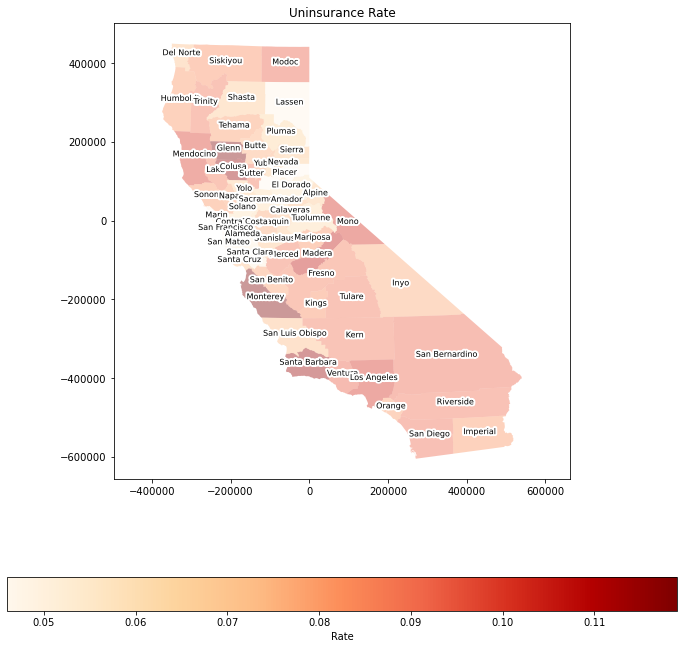

In [48]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.set(title='Uninsurance Rate')
ax.set_box_aspect(1)
cac_map_uninsured.plot(ax=ax, 
                          alpha=0.4, 
                          column='PCTELIG', 
                          legend=True, 
                          legend_kwds={'label': "Rate",
                                       'orientation': "horizontal"},
                          cmap='OrRd')

cac_map_uninsured.apply(lambda x: ax.annotate(s = x['NAME_PCASE'], 
                                    xy = x.geometry.centroid.coords[0], 
                                    ha = 'center', 
                                    color = 'black', 
                                    fontsize = 8,
                                    path_effects = [pe.withStroke(linewidth = 4, foreground = "white")]), axis = 1);

#fig.savefig('Figure21.jpg')

In [49]:
cac_tot = pd.merge(cac_map_overall_case[['FMNAME_PC', 'pop_perc']], 
                   cac_map_uninsured[['FMNAME_PC', 'PCTELIG']], 
                   left_on='FMNAME_PC', 
                   right_on='FMNAME_PC')

cac_tot.head()

,FMNAME_PC,pop_perc,PCTELIG
0,Del Norte County,0.043291,0.073
1,Siskiyou County,0.034865,0.084
2,Modoc County,0.000000,0.094
3,Humboldt County,0.026203,0.082
4,Trinity County,0.000000,0.090


Text(0.5, 1.0, 'Uninsured Rate vs Infected Percentage')

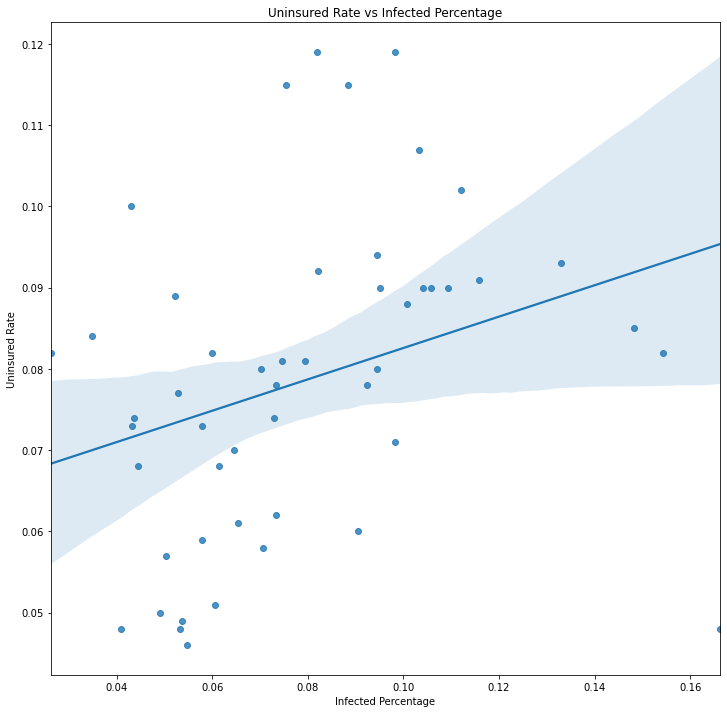

In [50]:
fig, ax = plt.subplots(figsize = (12, 12))
sns.regplot(x='pop_perc', y='PCTELIG', data=cac_tot[cac_tot['pop_perc']>0], ax=ax)
ax.set_xlabel('Infected Percentage')
ax.set_ylabel('Uninsured Rate')
ax.set_title('Uninsured Rate vs Infected Percentage')

#fig.savefig('Figure22.jpg')

In [51]:
cac_tot[cac_tot['pop_perc']>0].corr()

,pop_perc,PCTELIG
pop_perc,1.000000,0.310675
PCTELIG,0.310675,1.000000


### Elderly Percentage

In [52]:
data_ca_age = pd.read_csv("cc-est2019-alldata-06.csv")
data_ca_age = data_ca_age[data_ca_age["YEAR"] == 12]
data_ca_pop = data_ca_age[data_ca_age["AGEGRP"] == 0][["TOT_POP"]]

data_ca_pop = data_ca_race.groupby("CTYNAME").sum()[["TOT_POP"]]
data_ca_65up = data_ca_age.iloc[np.where(data_ca_age['AGEGRP']>13)]
data_ca_65up = data_ca_65up.groupby("CTYNAME").sum()[["TOT_POP"]]
data_ca_65up_perc = data_ca_65up / data_ca_pop
data_ca_65up_perc.head()

,TOT_POP
CTYNAME,
Alameda County,0.142858
Alpine County,0.263950
Amador County,0.275332
Butte County,0.183534
Calaveras County,0.280274


In [53]:
cac_map_65up = pd.merge(cac_map, 
                           data_ca_65up_perc, 
                           left_on='FMNAME_PC', 
                           right_on='CTYNAME')
cac_map_65up.head()

,NAME_PCASE,NAME_UCASE,FMNAME_PC,FMNAME_UC,ABBREV,NUM,ABCODE,FIPS,ANSI,ISLAND,Shape_Leng,Shape_Area,geometry,TOT_POP
0,Del Norte,DEL NORTE,Del Norte County,DEL NORTE COUNTY,DEL,8,c008,015,015,N,306175.156646,2.625847e+09,"POLYGON ((-346163.188 440231.625, -346195.812 ...",0.184201
1,Siskiyou,SISKIYOU,Siskiyou County,SISKIYOU COUNTY,SIS,47,c047,093,093,N,672205.907573,1.643940e+10,"POLYGON ((-291951.500 447930.719, -290572.656 ...",0.261352
2,Modoc,MODOC,Modoc County,MODOC COUNTY,MOD,25,c025,049,049,N,423574.415010,1.088488e+10,"POLYGON ((-120188.047 443056.938, -118144.953 ...",0.274969
3,Humboldt,HUMBOLDT,Humboldt County,HUMBOLDT COUNTY,HUM,12,c012,023,023,N,614580.877022,9.281900e+09,"POLYGON ((-339896.812 390343.812, -338720.375 ...",0.185817
4,Trinity,TRINITY,Trinity County,TRINITY COUNTY,TRI,53,c053,105,105,N,611269.176825,8.307254e+09,"POLYGON ((-208130.578 370133.250, -208098.922 ...",0.282865


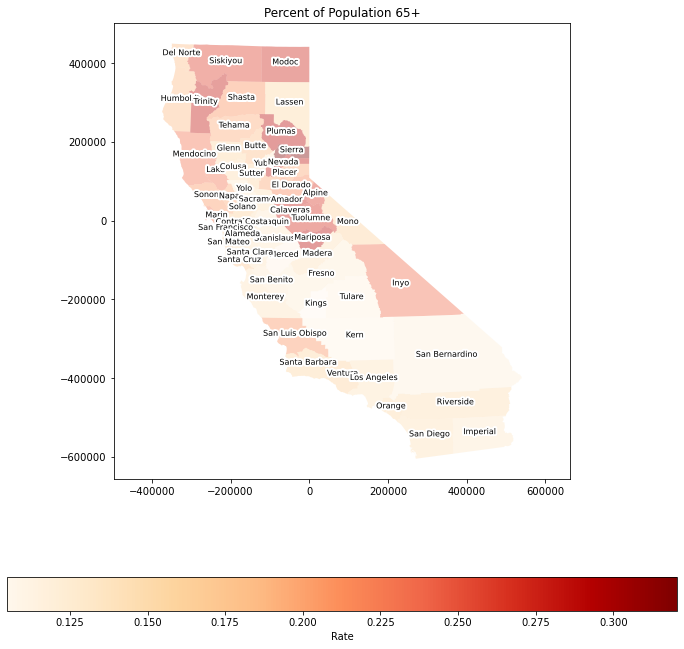

In [54]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.set(title='Percent of Population 65+')
ax.set_box_aspect(1)
cac_map_65up.plot(ax=ax, 
                  alpha=0.4, 
                  column='TOT_POP', 
                  legend=True, 
                  legend_kwds={'label': "Rate",
                               'orientation': "horizontal"},
                  cmap='OrRd')

cac_map_65up.apply(lambda x: ax.annotate(s = x['NAME_PCASE'], 
                                    xy = x.geometry.centroid.coords[0], 
                                    ha = 'center', 
                                    color = 'black', 
                                    fontsize = 8,
                                    path_effects = [pe.withStroke(linewidth = 4, foreground = "white")]), axis = 1);

#fig.savefig('Figure23.jpg')

In [55]:
cac_tot = pd.merge(cac_map_overall_case[['FMNAME_PC', 'pop_perc']], 
                   cac_map_65up[['FMNAME_PC', 'TOT_POP']], 
                   left_on='FMNAME_PC', 
                   right_on='FMNAME_PC')

cac_tot.head()

,FMNAME_PC,pop_perc,TOT_POP
0,Del Norte County,0.043291,0.184201
1,Siskiyou County,0.034865,0.261352
2,Modoc County,0.000000,0.274969
3,Humboldt County,0.026203,0.185817
4,Trinity County,0.000000,0.282865


Text(0.5, 1.0, 'Uninsured Rate vs Infected Percentage')

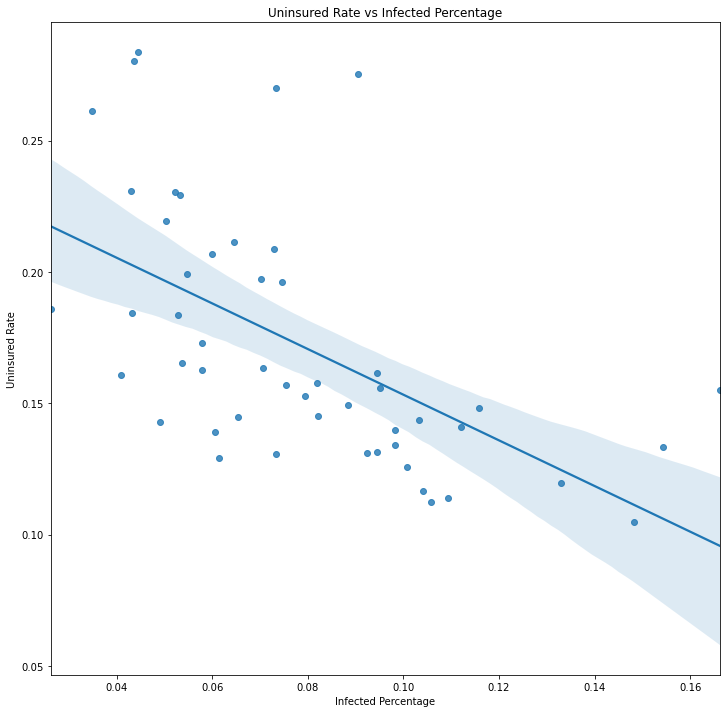

In [56]:
fig, ax = plt.subplots(figsize = (12, 12))
sns.regplot(x='pop_perc', y='TOT_POP', data=cac_tot[cac_tot['pop_perc']>0], ax=ax)
ax.set_xlabel('Infected Percentage')
ax.set_ylabel('Uninsured Rate')
ax.set_title('Uninsured Rate vs Infected Percentage')

#fig.savefig('Figure24.jpg')

In [57]:
cac_tot[cac_tot['pop_perc']>0].corr()

,pop_perc,TOT_POP
pop_perc,1.000000,-0.571717
TOT_POP,-0.571717,1.000000


In [58]:
data_age = data[data['age_group'].notna()]
data_age = data_age[data_age['age_group'] != 'Missing']
data_age = data_age[data_age['age_group']=='65+ years'].groupby("res_county").count()[['current_status']] \
/ data_age.groupby("res_county").count()[['current_status']]
data_age.reset_index()
data_age.head()

,current_status
res_county,
ALAMEDA,0.107914
AMADOR,0.187300
BUTTE,0.132128
CALAVERAS,0.203158
COLUSA,0.106943


In [59]:
cac_map_65up = pd.merge(cac_map_65up, 
                           data_age, 
                           left_on='NAME_UCASE', 
                           right_on='res_county')
cac_map_65up.head()

,NAME_PCASE,NAME_UCASE,FMNAME_PC,FMNAME_UC,ABBREV,NUM,ABCODE,FIPS,ANSI,ISLAND,Shape_Leng,Shape_Area,geometry,TOT_POP,current_status
0,Del Norte,DEL NORTE,Del Norte County,DEL NORTE COUNTY,DEL,8,c008,015,015,N,306175.156646,2.625847e+09,"POLYGON ((-346163.188 440231.625, -346195.812 ...",0.184201,0.049819
1,Siskiyou,SISKIYOU,Siskiyou County,SISKIYOU COUNTY,SIS,47,c047,093,093,N,672205.907573,1.643940e+10,"POLYGON ((-291951.500 447930.719, -290572.656 ...",0.261352,0.163911
2,Humboldt,HUMBOLDT,Humboldt County,HUMBOLDT COUNTY,HUM,12,c012,023,023,N,614580.877022,9.281900e+09,"POLYGON ((-339896.812 390343.812, -338720.375 ...",0.185817,0.089202
3,Shasta,SHASTA,Shasta County,SHASTA COUNTY,SHA,45,c045,089,089,N,537564.913338,9.976444e+09,"POLYGON ((-121409.383 352836.156, -119805.891 ...",0.211400,0.165261
4,Lassen,LASSEN,Lassen County,LASSEN COUNTY,LAS,18,c018,035,035,N,590157.695575,1.222738e+10,"POLYGON ((16.964 351949.781, 18.455 351880.781...",0.154973,0.037470


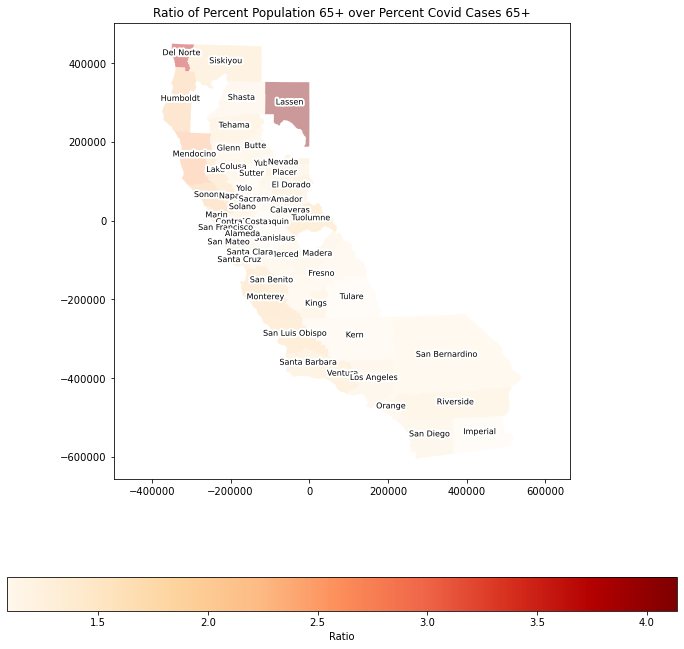

In [60]:
cac_map_65up['ratio'] = cac_map_65up['TOT_POP'] / cac_map_65up['current_status']

fig, ax = plt.subplots(figsize = (12, 12))
ax.set(title='Ratio of Percent Population 65+ over Percent Covid Cases 65+')
ax.set_box_aspect(1)
cac_map_65up.plot(ax=ax, 
                  alpha=0.4, 
                  column='ratio', 
                  legend=True, 
                  legend_kwds={'label': "Ratio",
                               'orientation': "horizontal"},
                  cmap='OrRd')

cac_map_65up.apply(lambda x: ax.annotate(s = x['NAME_PCASE'], 
                                    xy = x.geometry.centroid.coords[0], 
                                    ha = 'center', 
                                    color = 'black', 
                                    fontsize = 8,
                                    path_effects = [pe.withStroke(linewidth = 4, foreground = "white")]), axis = 1);

#fig.savefig('Figure25.jpg')

### Clustering

In [61]:
cac_tot = pd.merge(cac_map_overall_case, 
                   cac_map_pop[['FMNAME_PC', 'AA_PERC','WA_PERC','BA_PERC','NH_PERC','IAC_PERC']], 
                   left_on='FMNAME_PC', 
                   right_on='FMNAME_PC')

cac_tot = pd.merge(cac_tot, 
                   cac_map_uninsured[['FMNAME_PC', 'PCTELIG']], 
                   left_on='FMNAME_PC', 
                   right_on='FMNAME_PC')

cac_tot = pd.merge(cac_tot, 
                   cac_map_poverty[['FMNAME_PC', 'Rate']], 
                   left_on='FMNAME_PC', 
                   right_on='FMNAME_PC')
cac_tot.head()

,NAME_PCASE,NAME_UCASE,FMNAME_PC,FMNAME_UC,ABBREV,NUM,ABCODE,FIPS,ANSI,ISLAND,...,CTY,current_status,pop_perc,AA_PERC,WA_PERC,BA_PERC,NH_PERC,IAC_PERC,PCTELIG,Rate
0,Del Norte,DEL NORTE,Del Norte County,DEL NORTE COUNTY,DEL,8,c008,015,015,N,...,DEL NORTE,1204.0,0.043291,0.036543,0.921862,0.041594,0.001942,0.129009,0.073,0.152
1,Siskiyou,SISKIYOU,Siskiyou County,SISKIYOU COUNTY,SIS,47,c047,093,093,N,...,SISKIYOU,1518.0,0.034865,0.017889,0.964919,0.017192,0.003560,0.085762,0.084,0.152
2,Modoc,MODOC,Modoc County,MODOC COUNTY,MOD,25,c025,049,049,N,...,MODOC,0.0,0.000000,0.013322,0.970867,0.015812,0.003620,0.069449,0.094,0.152
3,Humboldt,HUMBOLDT,Humboldt County,HUMBOLDT COUNTY,HUM,12,c012,023,023,N,...,HUMBOLDT,3552.0,0.026203,0.033087,0.949923,0.016990,0.003312,0.093584,0.082,0.206
4,Trinity,TRINITY,Trinity County,TRINITY COUNTY,TRI,53,c053,105,105,N,...,TRINITY,0.0,0.000000,0.016782,0.974735,0.008482,0.002361,0.086040,0.090,0.180


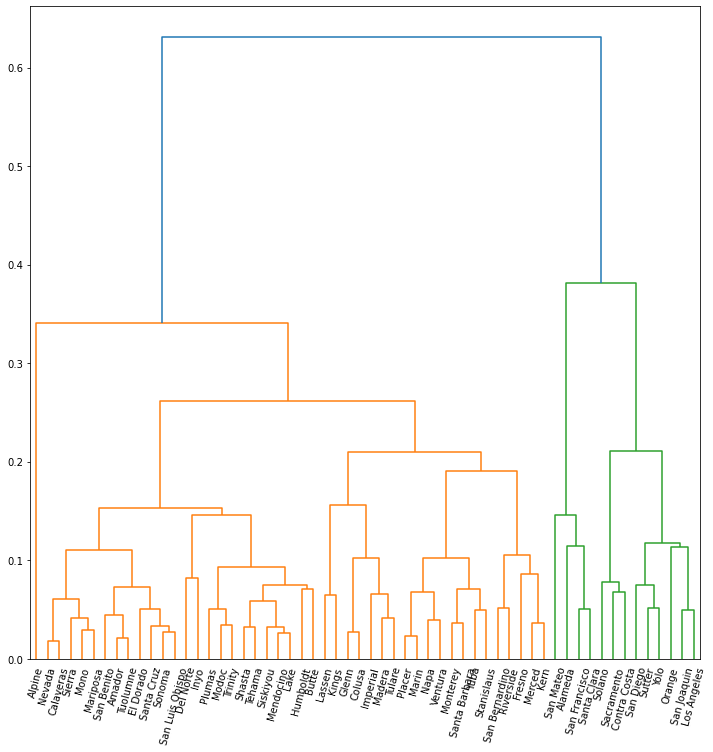

In [62]:
fig, ax = plt.subplots(figsize = (12, 12))
df_county_char = cac_tot.iloc[:,np.r_[0,15:23]]
df_county_char = df_county_char.set_index('NAME_PCASE')
z = hierarchy.linkage(df_county_char, method='complete', metric='euclidean')
dn = hierarchy.dendrogram(z, labels=df_county_char.index, leaf_rotation=75, leaf_font_size=10, ax=ax)

#fig.savefig('Figure26.jpg')

In [63]:
h = collections.defaultdict(list)
for k, v in zip(hierarchy.fcluster(z, 5, criterion='maxclust'), df_county_char.index):
    h[k].append(v)
h

defaultdict(list,
            {1: ['Del Norte',
              'Siskiyou',
              'Modoc',
              'Humboldt',
              'Trinity',
              'Shasta',
              'Tehama',
              'Plumas',
              'Butte',
              'Mendocino',
              'Sierra',
              'Lake',
              'Nevada',
              'El Dorado',
              'Sonoma',
              'Mono',
              'Amador',
              'Calaveras',
              'Tuolumne',
              'Mariposa',
              'Inyo',
              'Santa Cruz',
              'San Benito',
              'San Luis Obispo'],
             2: ['Lassen',
              'Glenn',
              'Yuba',
              'Colusa',
              'Placer',
              'Napa',
              'Marin',
              'Stanislaus',
              'Madera',
              'Merced',
              'Fresno',
              'Monterey',
              'Tulare',
              'Kings',
              'San Bernardino',
  

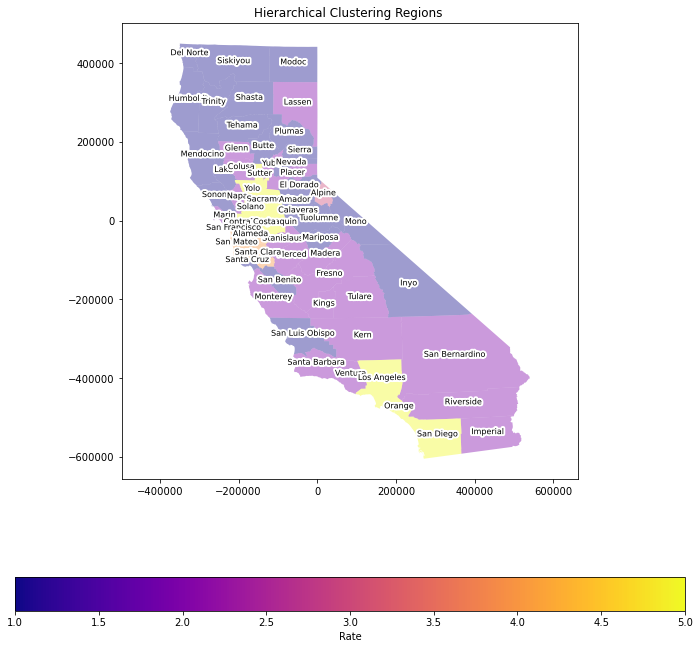

In [64]:
cac_tot['lab'] = hierarchy.fcluster(z, 5, criterion='maxclust')
fig, ax = plt.subplots(figsize = (12, 12))
ax.set(title='Hierarchical Clustering Regions ')
ax.set_box_aspect(1)
cac_tot.plot(ax=ax, 
                alpha=0.4, 
                column='lab', 
                legend=True, 
                legend_kwds={'label': "Rate",
                           'orientation': "horizontal"},
                cmap='plasma')

cac_tot.apply(lambda x: ax.annotate(s = x['NAME_PCASE'], 
                                    xy = x.geometry.centroid.coords[0], 
                                    ha = 'center', 
                                    color = 'black', 
                                    fontsize = 8,
                                    path_effects = [pe.withStroke(linewidth = 4, foreground = "white")]), axis = 1);

#fig.savefig('Figure27.jpg')

In [65]:
df_county_char[hierarchy.fcluster(z, 5, criterion='maxclust')==1].mean()

pop_perc    0.040786
AA_PERC     0.027431
WA_PERC     0.956140
BA_PERC     0.016429
NH_PERC     0.002641
IAC_PERC    0.060244
PCTELIG     0.077875
Rate        0.137375
dtype: float64

In [66]:
df_county_char[hierarchy.fcluster(z, 5, criterion='maxclust')==2].mean()

pop_perc    0.101453
AA_PERC     0.062266
WA_PERC     0.892538
BA_PERC     0.045195
NH_PERC     0.004108
IAC_PERC    0.038595
PCTELIG     0.087450
Rate        0.157950
dtype: float64

In [67]:
df_county_char[hierarchy.fcluster(z, 5, criterion='maxclust')==3].mean()

pop_perc    0.000000
AA_PERC     0.022814
WA_PERC     0.972117
BA_PERC     0.005070
NH_PERC     0.000000
IAC_PERC    0.274579
PCTELIG     0.070000
Rate        0.116000
dtype: float64

In [68]:
df_county_char[hierarchy.fcluster(z, 5, criterion='maxclust')==4].mean()

pop_perc    0.051095
AA_PERC     0.368550
WA_PERC     0.571972
BA_PERC     0.059478
NH_PERC     0.008402
IAC_PERC    0.019062
PCTELIG     0.049500
Rate        0.077750
dtype: float64

In [69]:
df_county_char[hierarchy.fcluster(z, 5, criterion='maxclust')==5].mean()

pop_perc    0.079581
AA_PERC     0.180506
WA_PERC     0.740151
BA_PERC     0.079342
NH_PERC     0.006765
IAC_PERC    0.028873
PCTELIG     0.076556
Rate        0.127667
dtype: float64